# Semantic Segmentation

Image semantic segmentation is more and more being of interest for computer vision and machine learning researchers. Many applications on the rise need accurate and efficient segmentation mechanisms: autonomous driving, indoor navigation, and even virtual or augmented reality systems to name a few. This work label the pixels of a road in images using a [Fully Convolutional Network (FCN)](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf).

I implementing the model using [Kitti Road dataset](http://www.cvlibs.net/datasets/kitti/eval_road.php). You can download the dataset from [here](http://www.cvlibs.net/download.php?file=data_road.zip). Extract the dataset in the `data` folder. This will create the folder data_road with all the training a test images. For the pre-processing process, I have build a `kitti.py` file to load data and build batch generator, using `kitti_source()` to run it.

## Check the KITTI dataset.

In [1]:
import os
import math
import kitti
import numpy as np
import cv2
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Configure the data get_source
get_source = kitti.get_source()
get_source.load_data('data/data_road', 0.1)

train_generator = get_source.train_generator
valid_generator = get_source.valid_generator
label_colors = get_source.label_colors

In [3]:
print('[i] # training samples:   ', get_source.num_training)
print('[i] # validation samples: ', get_source.num_validation)
print('[i] # classes:            ', get_source.num_classes)
print('[i] Image size:           ', get_source.image_size)

[i] # training samples:    261
[i] # validation samples:  28
[i] # classes:             2
[i] Image size:            (576, 160)


The function that we might need in the preprocessing.

In [4]:
def draw_labels(img, labels, label_colors, convert=True):
    """
    Draw the labels on top of the input image
    :param img:          the image being classified
    :param labels:       the output of the neural network
    :param label_colors: the label color map defined in the source
    :param convert:      should the output be converted to RGB
    """
    labels_colored = np.zeros_like(img)
    for label in label_colors:
        label_mask = labels == label
        labels_colored[label_mask] = label_colors[label]
    img = cv2.addWeighted(img, 1, labels_colored, 0.8, 0)
    if not convert:
        return img
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def draw_labels_batch(imgs, labels, label_colors, convert=True):
    """
    Perform `draw_labels` on all the images in the batch
    """
    imgs_labelled = np.zeros_like(imgs)
    for i in range(imgs.shape[0]):
        imgs_labelled[i, :, :, :] = draw_labels(imgs[i, :, :, :],
                                                labels[i, :, :],
                                                label_colors,
                                                convert)
    return imgs_labelled

Store 10 annotated training samples in the `output`.

Noted that although we see that the image is a little wierd, it seems quiet right in the output folder.

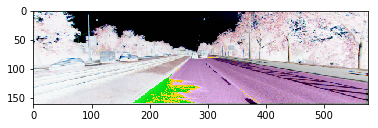

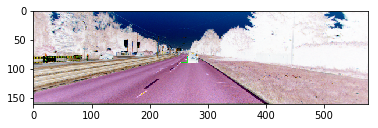

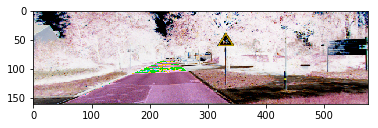

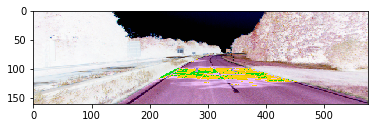

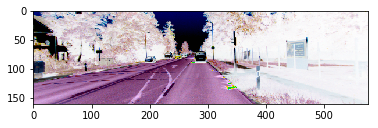

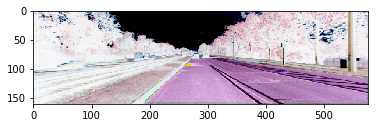

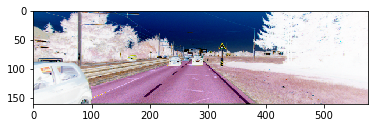

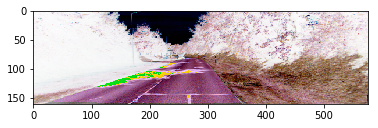

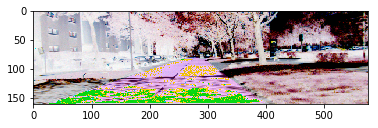

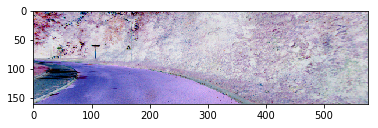

In [5]:
gen = get_source.train_generator(10)
x, y = next(gen)
output_dir='output'# Store output images

labels = tf.placeholder(tf.float32,shape=[None, None, None, get_source.num_classes])
label_mapper = tf.argmax(labels, axis=3)

with tf.Session() as sess:
    y_mapped = sess.run(label_mapper, feed_dict={labels: y})

imgs_labelled = draw_labels_batch(x, y_mapped, get_source.label_colors, False)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
for i in range(x.shape[0]):
    filename = 'outpout_{:04d}.png'.format(i)
    plt.figure()
    plt.imshow(imgs_labelled[i, :, :, :])
    cv2.imwrite(output_dir + '/' + filename, imgs_labelled[i, :, :, :])

In [6]:
# Check if all the labels are correct

def check_label_validity(y, ny):
    # Check validity of the lavel
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            for k in range(y.shape[2]):
                nnzeros = np.count_nonzero(y[i, j, k, :])
                has_one = 1 in y[i, j, k, :]
                if nnzeros != 1 or not has_one:
                    print('{} label for pixel ({}, {}) is invalid'.format(ny[i], j, k))
                    print(y[i, j, k, :])
                    
gen = get_source.train_generator(10, names=True)
n_batches = int(math.ceil(get_source.num_training / 10))

for x, y, nx, ny in tqdm(gen, total=n_batches,
                         desc='Checking training labels', unit='batches'):
    check_label_validity(y, ny)

Checking training labels: 100%|████████████████████████| 27/27 [02:34<00:00,  4.26s/batches]


Then check the upscale.

Many thanks to http://cv-tricks.com/image-segmentation/transpose-convolution-in-tensorflow/

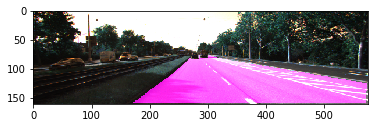

In [7]:
from upscale import upsample
img=cv2.imread('output/outpout_0000.png')
plt.imshow(img)

In [8]:
print('Original size:', img.shape)

Original size: (160, 576, 3)


In [9]:
imgs = np.zeros([1, *img.shape], dtype=np.float32)
imgs[0,:,:,:] = img
img_input = tf.placeholder(tf.float32, [None, *img.shape])
upscale = upsample(img_input, 3, 8,'upscaled')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    upscaled = sess.run(upscale, feed_dict={img_input: imgs})
cv2.imwrite('upscaled-img.png', upscaled[0,:, :, :])
print('Upscaled:', upscaled.shape[1:])

Upscaled: (1280, 4608, 3)


## Implement VGG into FCN

### Set parameter

In [13]:
DATA_DIR = './data'
VGG_DIR='./data/vgg'
EPOCHS = 20
BATCH_SIZE = 16
TENSORBOARD_DIR='./tensorboard_dir'
CHECKPOINT_INTERVAL=5

NUM_CLASSES = 2

RUNS_DIR = './runs'
MODEL_DIR = './models_3col'

Reshape the tensor so that it matches the number of classes and output size

In [11]:
def reshape(x, num_classes, upscale_factor, name):
    """
    Reshape the tensor so that it matches the number of classes and output size
    :param x:              input tensor
    :param num_classes:    number of classes
    :param upscale_factor: scaling factor
    :param name:           name of the resulting tensor
    :return:               reshaped tensor
    """
    with tf.variable_scope(name):
        w_shape = [1, 1, int(x.get_shape()[3]), num_classes]
        w = tf.Variable(tf.truncated_normal(w_shape, 0, 0.1),
                        name=name + '_weights')
        b = tf.Variable(tf.zeros(num_classes), name=name + '_bias')
        resized = tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='VALID',
                               name=name + '_resized')
        resized = tf.nn.bias_add(resized, b, name=name + '_add_bias')
    upsampled = upsample(resized, num_classes, upscale_factor,
                         name + '_upsampled')
    return upsampled

## Implementing model(VGG in FCN)

In [20]:
class model:
    def __init__(self, session):
        self.session = session

    def build_from_vgg(self, vgg_dir, num_classes=2):
        """
        Build the model for training based on a pre-define vgg16 model.
        :param vgg_dir:       directory where the vgg model should be stored
        :param num_classes:   number of classes
        """
        self.num_classes = num_classes
        self.__load_vgg(vgg_dir)
        self.__make_result_tensors()

    def build_from_metagraph(self, metagraph_file, checkpoint_file):
        """
        Build the model for inference from a metagraph shapshot and weights
        checkpoint.
        """
        sess = self.session
        saver = tf.train.import_meta_graph(metagraph_file)
        saver.restore(sess, checkpoint_file)
        self.image_input = sess.graph.get_tensor_by_name('image_input:0')
        self.keep_prob = sess.graph.get_tensor_by_name('keep_prob:0')
        self.logits = sess.graph.get_tensor_by_name('sum/Add_1:0')
        self.softmax = sess.graph.get_tensor_by_name('result/Softmax:0')
        self.classes = sess.graph.get_tensor_by_name('result/ArgMax:0')

    def __load_vgg(self, vgg_dir):
        sess = self.session
        graph = tf.saved_model.loader.load(sess, ['vgg16'], vgg_dir)
        self.image_input = sess.graph.get_tensor_by_name('image_input:0')
        self.keep_prob = sess.graph.get_tensor_by_name('keep_prob:0')
        self.vgg_layer3 = sess.graph.get_tensor_by_name('layer3_out:0')
        self.vgg_layer4 = sess.graph.get_tensor_by_name('layer4_out:0')
        self.vgg_layer7 = sess.graph.get_tensor_by_name('layer7_out:0')

    def __make_result_tensors(self):
        vgg3_reshaped = reshape(self.vgg_layer3, self.num_classes, 8,
                                'layer3_resize')
        vgg4_reshaped = reshape(self.vgg_layer4, self.num_classes, 16,
                                'layer4_resize')
        vgg7_reshaped = reshape(self.vgg_layer7, self.num_classes, 32,
                                'layer7_resize')

        with tf.variable_scope('sum'):
            self.logits = tf.add(vgg3_reshaped,
                                 tf.add(2 * vgg4_reshaped, 4 * vgg7_reshaped))
        with tf.name_scope('result'):
            self.softmax = tf.nn.softmax(self.logits)
            self.classes = tf.argmax(self.softmax, axis=3)

    def get_optimizer(self, labels, learning_rate=1e-4):
        with tf.variable_scope('reshape'):
            labels_reshaped = tf.reshape(labels, [-1, self.num_classes])
            logits_reshaped = tf.reshape(self.logits, [-1, self.num_classes])
            losses = tf.nn.softmax_cross_entropy_with_logits(
                labels=labels_reshaped,
                logits=logits_reshaped)
            loss = tf.reduce_mean(losses)
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate)
            optimizer = optimizer.minimize(loss)
        return optimizer, loss

Create Model

In [ ]:
with tf.Session() as sess:
    print('Creating the model...')
    net = model(sess)
    net.build_from_vgg(VGG_DIR, get_source.num_classes)

    labels = tf.placeholder(tf.float32,
                            shape=[None, None, None, get_source.num_classes])

    optimizer, loss = net.get_optimizer(labels)

    summary_writer = tf.summary.FileWriter(args.tensorboard_dir, sess.graph)
    saver = tf.train.Saver(max_to_keep=10)

    label_mapper = tf.argmax(labels, axis=3)
    n_train_batches = int(math.ceil(get_source.num_training / args.batch_size))

    initialize_uninitialized_variables(sess)
    print('Training...')

    # Summaries
    validation_loss = tf.placeholder(tf.float32)
    validation_loss_summary_op = tf.summary.scalar('validation_loss',
                                                   validation_loss)

    training_loss = tf.placeholder(tf.float32)
    training_loss_summary_op = tf.summary.scalar('training_loss',
                                                 training_loss)

    validation_img = tf.placeholder(tf.float32, shape=[None, None, None, 3])
    validation_img_gt = tf.placeholder(tf.float32, shape=[None, None, None, 3])
    validation_img_summary_op = tf.summary.image('validation_img',
                                                 validation_img)
    validation_img_gt_summary_op = tf.summary.image('validation_img_gt',
                                                    validation_img_gt)
    validation_img_summary_ops = [validation_img_summary_op,
                                  validation_img_gt_summary_op]

    for e in range(args.epochs):
        # Train
        generator = train_generator(args.batch_size)
        description = '[i] Epoch {:>2}/{}'.format(e + 1, args.epochs)
        training_loss_total = 0
        for x, y in tqdm(generator, total=n_train_batches,
                         desc=description, unit='batches'):
            feed = {net.image_input: x,
                    labels: y,
                    net.keep_prob: 0.5}
            loss_batch, _ = sess.run([loss, optimizer], feed_dict=feed)
            training_loss_total += loss_batch * x.shape[0]
        training_loss_total /= get_source.num_training

        # Validate
        generator = valid_generator(args.batch_size)
        validation_loss_total = 0
        imgs = None
        img_labels = None
        img_labels_gt = None
        for x, y in generator:
            feed = {net.image_input: x,
                    labels: y,
                    net.keep_prob: 1}
            loss_batch, img_classes, y_mapped = sess.run([loss,
                                                          net.classes,
                                                          label_mapper],
                                                         feed_dict=feed)
            validation_loss_total += loss_batch * x.shape[0]

            if imgs is None:
                imgs = x[:3, :, :, :]
                img_labels = img_classes[:3, :, :]
                img_labels_gt = y_mapped[:3, :, :]

        validation_loss_total /= get_source.num_validation

        # Write loss summary
        feed = {validation_loss: validation_loss_total,
                training_loss: training_loss_total}
        loss_summary = sess.run([validation_loss_summary_op,
                                 training_loss_summary_op],
                                feed_dict=feed)

        summary_writer.add_summary(loss_summary[0], e)
        summary_writer.add_summary(loss_summary[1], e)

        # Write image summary every 5 epochs
        if e % 5 == 0:
            imgs_inferred = draw_labels_batch(imgs, img_labels, label_colors)
            imgs_gt = draw_labels_batch(imgs, img_labels_gt, label_colors)

            feed = {validation_img: imgs_inferred,
                    validation_img_gt: imgs_gt}
            validation_img_summaries = sess.run(validation_img_summary_ops,
                                                feed_dict=feed)
            summary_writer.add_summary(validation_img_summaries[0], e)
            summary_writer.add_summary(validation_img_summaries[1], e)

        # Save a checktpoint
        if (e + 1) % args.checkpoint_interval == 0:
            checkpoint = '{}/e{}.ckpt'.format(args.name, e + 1)
            saver.save(sess, checkpoint)
            print('Checkpoint saved:', checkpoint)

    checkpoint = '{}/final.ckpt'.format(args.name)
    saver.save(sess, checkpoint)
    print('Checkpoint saved:', checkpoint)